# MOrdReD: Ordinal autoregression with recurrent neural networks

### Introduction

This Python library accompanies our [work](https://arxiv.org/abs/1803.09704). MOrdReD enables time series forecasting in an autoregressive and ordinal fashion. This simply means two things: that a new sample $x_{t+1}$ is forecasted by looking at previous observations $x_t, x_{t-1}..., x_{t-p}$ for some lookback $p$. 

Our framework provides an implementation of our ordinal autoregression framework (via Keras) described in the paper above; however, it also provides a flexible and amicable interface to set up time series forecasting tasks (parameter optimisation, model selection, model evaluation, long-term prediction, plotting) with either our prediction framework, or other well-established techniques, such as Gaussian Processes (via GPy) or Dynamic AR models (via statsmodels).

The following notebook takes us through the most basic example: loading and preparing a time series dataset, choosing a model, and evaluating it.

In [14]:
%matplotlib inline

from ordinal_tsf.dataset import *
from ordinal_tsf.model import *
from ordinal_tsf.session import *
from ordinal_tsf.util import cartesian
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"

plt.style.use('seaborn-ticks')
matplotlib.rcParams['figure.figsize'] = (20.0, 16.0)
matplotlib.rcParams['font.serif'] = 'times'
labelsize = 26
titlesize=32
params= { 
    'text.usetex':True, "font.family": "serif", "font.serif": ["Computer Modern"],
    'font.family':'serif', 'font.serif': ["Times", "Times New Roman"],
    'legend.fontsize':labelsize, 'axes.labelsize':labelsize, 'axes.titlesize':titlesize, 
    'xtick.labelsize' :labelsize, 'ytick.labelsize' : labelsize
}
matplotlib.rcParams.update(params)

## Starting a session

All interactions with this library are managed by a Session object. This guarantees that other objects such as preprocessed datasets, models, predictions and plots are kept in an orderly way. This also makes sure the project's structure is cohererent and queryable by different modules.

In practice, Sessions are meant to group experiments on the same time series, regardless of whether they are ordinal or real-valued. The id provided as a constructor argument is the name of the folder that will store all of the session's objects.

For this introductory example, we will work with the Mackey Glass chaotic system.

Opening session: mg/...


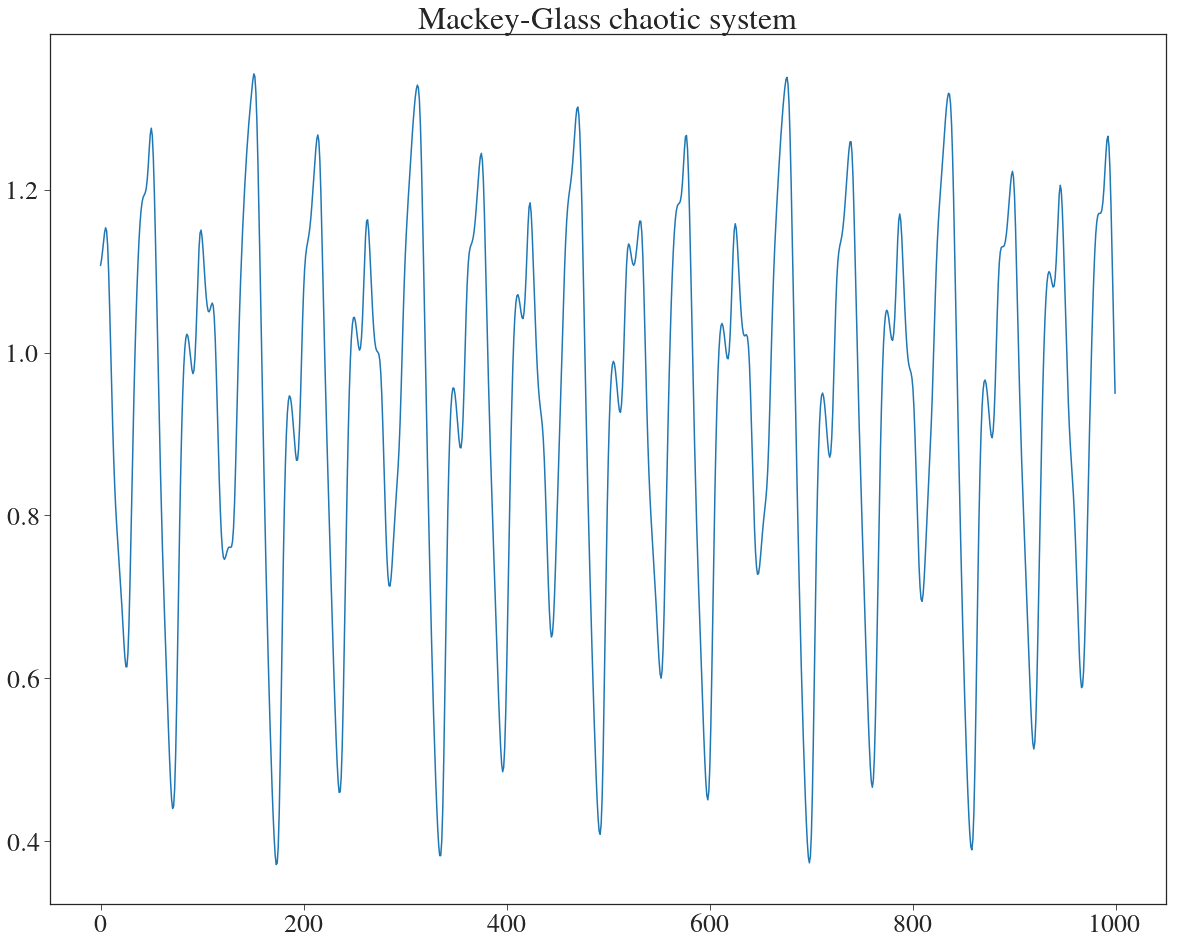

In [15]:
sess = Session('mg')
x = pd.read_feather('mg.feather').values
plt.plot(x[:1000])
plt.title('Mackey-Glass chaotic system')
plt.show()

## Preparing the dataset

All Ordinal TSF models work with the (autoregressive) Dataset interface. This provides a transparent way of framing a time series, as well as applying preprocessing transformations such as: standardising, adding white noise, quantising (binning/discretising), etc. Users can also add any additional data preprocessing steps they may need by providing an object whose class inherits from DatasetPreprocessingStep, as defined in the .dataset package.

For this example, we will only make the time series zero-mean, unit-variance and quantise it in 85 equally-distributed bins over the time series' range. The first 70% of the time series' samples will then be used as the training set for our model, and the validation and test sets are made by equally splitting the remaining 30%.

In [24]:
lookback = 100
horizon = 100
ordinal_bins = 85

stand = Standardiser()
quant = Quantiser(ordinal_bins)

dataset = Dataset(x, lookback + horizon + 1, p_val=0.15, p_test=0.15, preprocessing_steps=[stand, quant])

print "Time series framed into {} training frames with {} {}-feature observations at each timestep\n".format(*dataset.train_frames.shape)

print dataset

Time series framed into 14559 training frames with 201 85-feature observations at each timestep

Dataset with properties:
zero_mean_unit_var:True
bin_delta:0.0494988267428
ts_std:0.234664381011
bins:[-2.37251619 -2.32301736 -2.27351853 -2.22401971 -2.17452088 -2.12502205
 -2.07552323 -2.0260244  -1.97652557 -1.92702675 -1.87752792 -1.82802909
 -1.77853027 -1.72903144 -1.67953261 -1.63003379 -1.58053496 -1.53103613
 -1.48153731 -1.43203848 -1.38253965 -1.33304082 -1.283542   -1.23404317
 -1.18454434 -1.13504552 -1.08554669 -1.03604786 -0.98654904 -0.93705021
 -0.88755138 -0.83805256 -0.78855373 -0.7390549  -0.68955608 -0.64005725
 -0.59055842 -0.5410596  -0.49156077 -0.44206194 -0.39256312 -0.34306429
 -0.29356546 -0.24406664 -0.19456781 -0.14506898 -0.09557016 -0.04607133
  0.0034275   0.05292632  0.10242515  0.15192398  0.2014228   0.25092163
  0.30042046  0.34991928  0.39941811  0.44891694  0.49841576  0.54791459
  0.59741342  0.64691224  0.69641107  0.7459099   0.79540873  0.8449075

## Starting an experiment



In [25]:
experiment = sess.start_experiment(dataset, MordredStrategy)

## Model selection



In [26]:
mordred_search_space = {'lam': [1e-6, 1e-7],
                        'dropout_rate': [0.35],
                        'units': [75, 150],
                        'lookback': [lookback],
                        'horizon': [horizon],
                        'ordinal_bins': [ordinal_bins],
                        'n_channels': [1]}

first_prediction_index = 121
validation_predictive_horizon = 300

In [27]:
selector = Selector(first_prediction_index, validation_predictive_horizon)
continuous_ground_truth = dataset.apply_partial_preprocessing('val', [selector, stand])
ordinal_ground_truth = dataset.apply_partial_preprocessing('val', [selector, stand, quant])

validation_tests = [TestDefinition('mse', continuous_ground_truth),
                    TestDefinition('nll', ordinal_ground_truth),
                    TestDefinition('cum_nll', ordinal_ground_truth)]

validation_plots = {'plot_median_2std': {'ground_truth':continuous_ground_truth},
                    'plot_cum_nll': {'binned_ground_truth': ordinal_ground_truth},
                    'plot_like': {}}

In [28]:
best_models = experiment.choose_model(validation_tests,
                                      mordred_search_space.keys(),
                                      cartesian(mordred_search_space.values()),
                                      first_prediction_index,
                                      validation_predictive_horizon,
                                      plots=validation_plots,
                                      fit_kwargs={'epochs': 50, 'batch_size': 256, 'validation_split': 0.15},
                                      eval_kwargs={'mc_samples': 20},
                                      mode='val')

Training new model with specification: {'lam': 1e-06, 'dropout_rate': 0.35, 'lookback': 100, 'ordinal_bins': 85, 'horizon': 100, 'n_channels': 1, 'units': 75}
Train on 12375 samples, validate on 2184 samples
Epoch 1/50
 - 62s - loss: 4.0598 - categorical_crossentropy: 4.0591 - val_loss: 3.4483 - val_categorical_crossentropy: 3.4474
Epoch 2/50
 - 59s - loss: 3.2970 - categorical_crossentropy: 3.2959 - val_loss: 2.8757 - val_categorical_crossentropy: 2.8743
Epoch 3/50
 - 58s - loss: 2.8786 - categorical_crossentropy: 2.8768 - val_loss: 2.5196 - val_categorical_crossentropy: 2.5175
Epoch 4/50
 - 58s - loss: 2.5941 - categorical_crossentropy: 2.5917 - val_loss: 2.2564 - val_categorical_crossentropy: 2.2537
Epoch 5/50
 - 58s - loss: 2.3852 - categorical_crossentropy: 2.3821 - val_loss: 2.0576 - val_categorical_crossentropy: 2.0540
Epoch 6/50
 - 58s - loss: 2.2105 - categorical_crossentropy: 2.2066 - val_loss: 1.8888 - val_categorical_crossentropy: 1.8845
Epoch 7/50
 - 58s - loss: 2.0679 - c

Epoch 12/50
 - 61s - loss: 1.3163 - categorical_crossentropy: 1.3044 - val_loss: 1.0407 - val_categorical_crossentropy: 1.0284
Epoch 13/50
 - 61s - loss: 1.2615 - categorical_crossentropy: 1.2488 - val_loss: 0.9886 - val_categorical_crossentropy: 0.9754
Epoch 14/50
 - 62s - loss: 1.2133 - categorical_crossentropy: 1.1996 - val_loss: 0.9537 - val_categorical_crossentropy: 0.9396
Epoch 15/50
 - 61s - loss: 1.1739 - categorical_crossentropy: 1.1595 - val_loss: 0.9167 - val_categorical_crossentropy: 0.9018
Epoch 16/50
 - 61s - loss: 1.1349 - categorical_crossentropy: 1.1196 - val_loss: 0.8787 - val_categorical_crossentropy: 0.8631
Epoch 17/50
 - 61s - loss: 1.1050 - categorical_crossentropy: 1.0889 - val_loss: 0.8460 - val_categorical_crossentropy: 0.8295
Epoch 18/50
 - 61s - loss: 1.0757 - categorical_crossentropy: 1.0589 - val_loss: 0.8208 - val_categorical_crossentropy: 0.8036
Epoch 19/50
 - 61s - loss: 1.0487 - categorical_crossentropy: 1.0312 - val_loss: 0.8026 - val_categorical_cross

Epoch 31/50
 - 58s - loss: 1.2340 - categorical_crossentropy: 1.2318 - val_loss: 0.9072 - val_categorical_crossentropy: 0.9050
Epoch 32/50
 - 58s - loss: 1.2242 - categorical_crossentropy: 1.2220 - val_loss: 0.8926 - val_categorical_crossentropy: 0.8904
Epoch 33/50
 - 58s - loss: 1.2140 - categorical_crossentropy: 1.2117 - val_loss: 0.8871 - val_categorical_crossentropy: 0.8848
Epoch 34/50
 - 58s - loss: 1.2043 - categorical_crossentropy: 1.2019 - val_loss: 0.8713 - val_categorical_crossentropy: 0.8689
Epoch 35/50
 - 58s - loss: 1.1966 - categorical_crossentropy: 1.1942 - val_loss: 0.8703 - val_categorical_crossentropy: 0.8679
Epoch 36/50
 - 58s - loss: 1.1888 - categorical_crossentropy: 1.1863 - val_loss: 0.8606 - val_categorical_crossentropy: 0.8581
Epoch 37/50
 - 58s - loss: 1.1799 - categorical_crossentropy: 1.1774 - val_loss: 0.8541 - val_categorical_crossentropy: 0.8516
Epoch 38/50
 - 58s - loss: 1.1729 - categorical_crossentropy: 1.1703 - val_loss: 0.8467 - val_categorical_cross

## Prediction analysis

In [29]:
best_models

{'cum_nll': {'cum_nll': -19845.07938107477,
  'dropout_rate': 0.35,
  'horizon': 100,
  'lam': 1e-06,
  'lookback': 100,
  'mse': 0.3459351451105453,
  'n_channels': 1,
  'nll': 23.366935981013796,
  'ordinal_bins': 85,
  'units': 75},
 'mse': {'cum_nll': -10929.083804162434,
  'dropout_rate': 0.35,
  'horizon': 100,
  'lam': 1e-06,
  'lookback': 100,
  'mse': 0.16663790526463065,
  'n_channels': 1,
  'nll': 189.5265188900529,
  'ordinal_bins': 85,
  'units': 150},
 'nll': {'cum_nll': -19845.07938107477,
  'dropout_rate': 0.35,
  'horizon': 100,
  'lam': 1e-06,
  'lookback': 100,
  'mse': 0.3459351451105453,
  'n_channels': 1,
  'nll': 23.366935981013796,
  'ordinal_bins': 85,
  'units': 75}}

MSE: 0.198050307877 +- 0.0262471117184
NLL: 29.2952095558


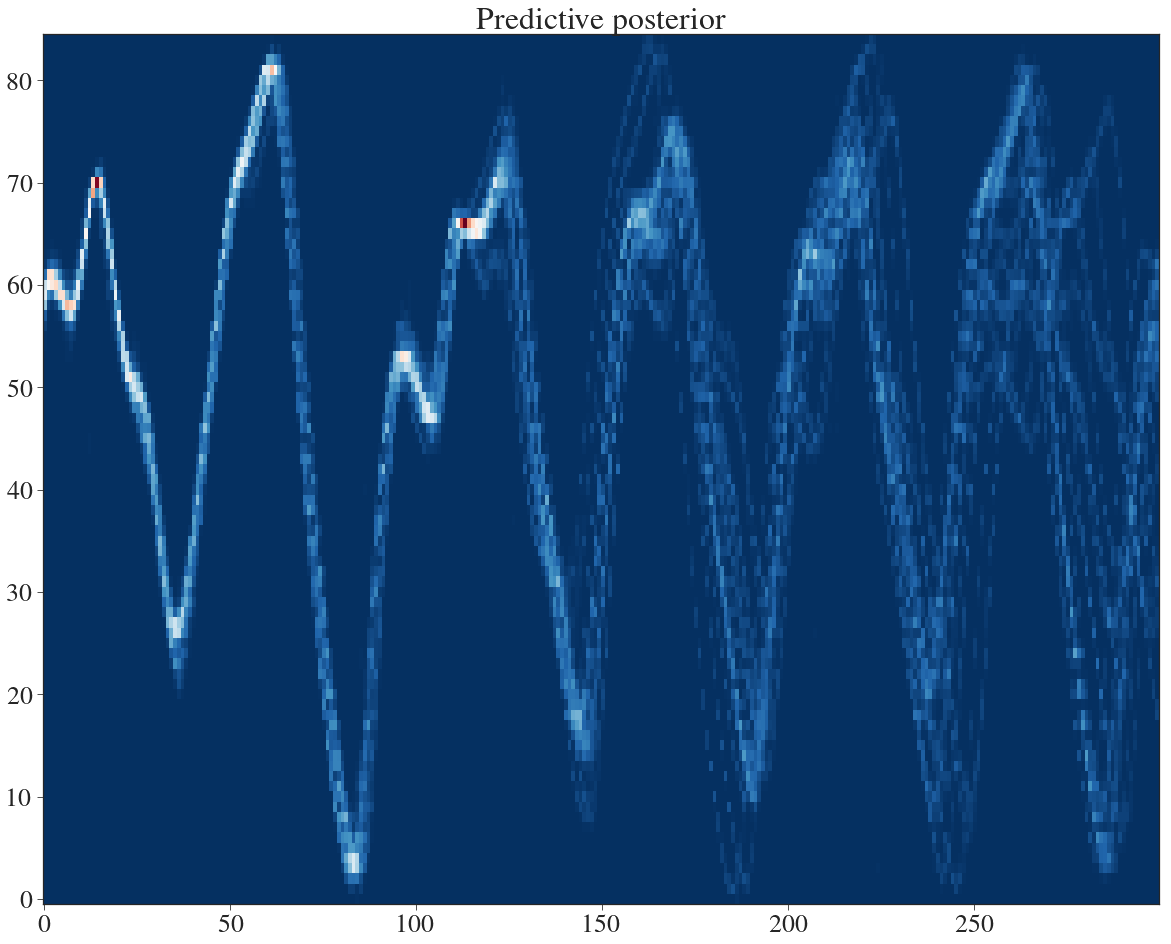

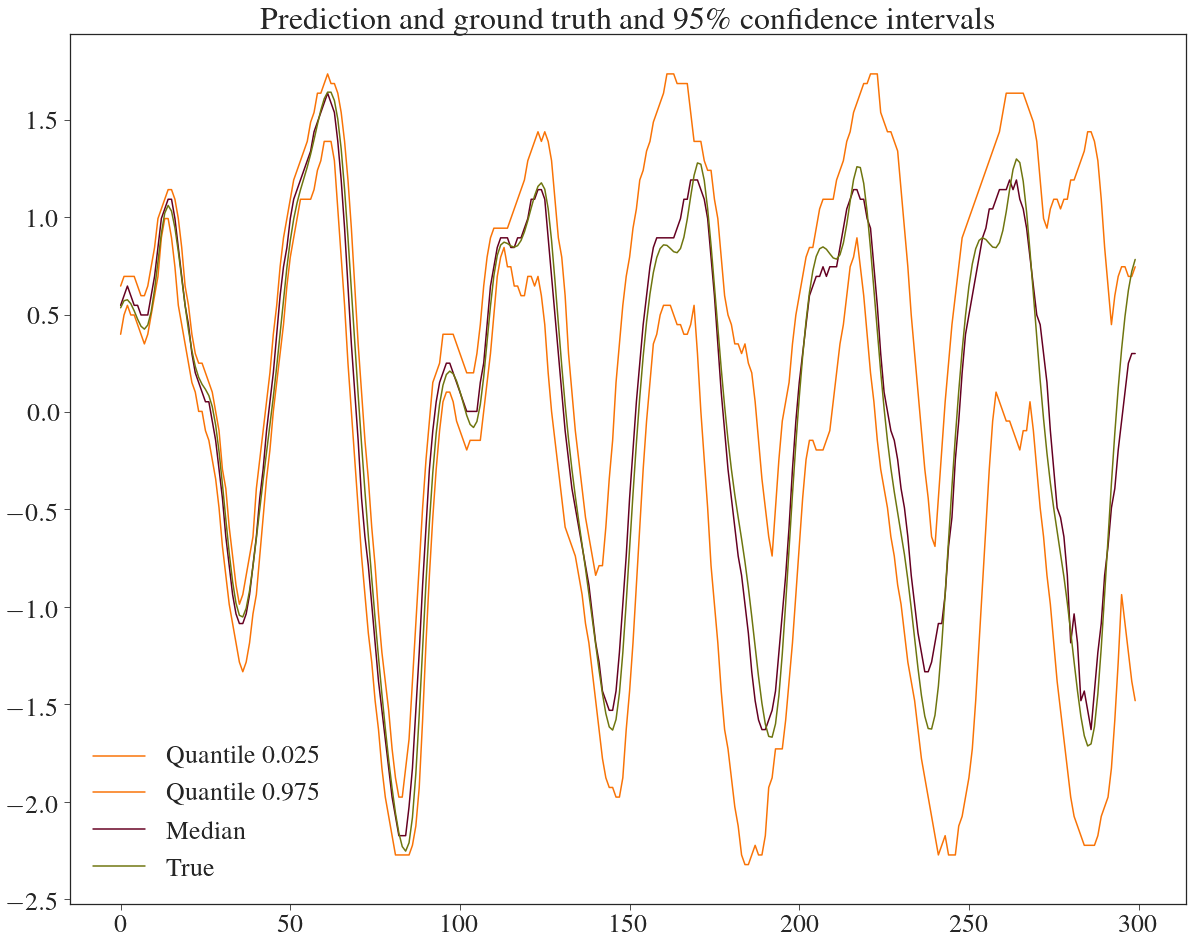

In [29]:
print 'MSE: {} +- {}'.format(*prediction.mse_and_std(continuous_ground_truth))
print 'NLL: {}'.format(prediction.nll(ordinal_ground_truth))

prediction.plot_like(plt)
plt.title('Predictive posterior')
plt.show()

prediction.plot_median_2std(plt, continuous_ground_truth)
plt.title('Prediction and ground truth and 95\% confidence intervals')
plt.show()

## Model training and selection

The Session object manages model fitting and hyperparameter selection. Model families are provided via wrapper Strategy interfaces, and the following are currently available:

1. MOrdReD
2. Real-valued sequence-to-sequence
3. Gaussian Process

Model selection is currently done by hypergrid search, which is provided as a dictionary with param:param_value. For instance, the hypergrid below fixes values for the dropout rate, lookback and horizon hyperparameters, as well as and number of ordinal bins and input channels; but it also gives a list of possible L2 regularisation hyperparameters and number of hidden units to be used in the intermediate layers of Mordred. 

Valid keys are described in detail in the package's documentation, but these roughly map to the input arguments to be received by the Keras constructors (or a list of kernels in the case of GPs).



On top of the hypergrid, the model selector also expects a validation time series, which includes a seed to feed the model, and a ground truth to compare the prediction with. This selection can be done via a Selector, which in this example will filter 300 samples starting from time index 121.

Such comparisons, or metrics, might expect the ground truth in different formats, or with only a subset of the preprocessing steps applied on the training data. These are applied to the selected sub-time series.